# A Joint Fundamentals and Polling Dynamic Generalized Linear Model for

Predicting the Icelandic Parliamentary Elections

Brynjólfur Gauti Guðrúnar Jónsson  
Rafael Daniel Vias  
Hafsteinn Einarsson  
Agnar Freyr Helgason

## Introduction

This report outlines the methodology behind forecasting the outcome of the upcoming Icelandic Parliamentary Elections scheduled for November 30th. The forecast is based on a joint model that combines two components:

1.  A dynamic linear model for polling data that incorporates polling house effects and accounts for house-specific biases as well as overdispersion
2.  A fundamentals model that leverages historical election results, incumbency status, and previous vote shares

By combining these two sources of information, we aim to produce more accurate and robust forecasts that account for both the current state of public opinion and structural factors that influence election outcomes.

## Model Specification

Our model combines two components:

1.  A dynamic linear model for polling data that captures temporal evolution of party support and polling house effects
2.  A fundamentals model that incorporates structural factors from historical election data

### Notation

#### Input Data

##### Polling Data

-   $P$: Number of political parties *(including the Other category)*
-   $T$: Number of time points (dates), $1, \dots, T$, where $T$ is the date of the next election.
-   $H$: Number of polling houses
-   $N$: Number of observations (polls)
-   $y_{n,p}$: Count of responses for party $p$ in poll $n$
-   $\Delta_t$: The time difference between polls at $t-1$ and $t$ in days

##### Fundamentals Data

-   $D_f$: Number of past elections
-   $P_f$: Number of parties in historical data
-   $y_{p,d}^{(f)}$: Vote share for party $p$ in election $d$
-   $x_{p,d}$: Previous vote share for party $p$ in election $d$
-   $I_{p,d}$: Years party $p$ has been incumbent at election $d$
-   $v_{p,d}$: Inflation rate (%) for party $p$ at election $d$ (if incumbent)
-   $g_{p,d}$: GDP growth rate (%) for party $p$ at election $d$ (if incumbent)

#### Parameters

##### Polling Model Parameters

-   $\beta_{p,t}$: Latent support for party $p$ at time $t$ (for $p = 2,\ldots,P$)
-   $\gamma_{p,h}$: Effect of polling house $h$ for party $p$ (for $p = 2,\ldots,P$)
-   $\mu_{\gamma,p}$: Mean house effect for party $p$
-   $\sigma_{\gamma,p}$: Scale of house effects for party $p$
-   $\sigma_p$: Scale parameter for the random walk of party $p$
-   $\phi$: Overdispersion parameter

##### Fundamentals Model Parameters

-   $\alpha_p$: Base support level for party $p$
-   $\beta_{\text{lag}}$: Effect of previous vote share
-   $\beta_{\text{years inc}}$: Effect of log years as incumbent
-   $\beta_{\text{vnv}}$: Effect of excess inflation for incumbent parties
-   $\beta_{\text{growth}}$: Effect of GDP growth for incumbent parties
-   $\phi_f$: Overdispersion parameter for the fundamentals model
-   $\tau_f$: Scaling factor for the prior of the support during the next election

### Data Preprocessing

The economic variables are transformed to better capture their effects:

-   Incumbent years are log-transformed: $\log(I_{p,d})$
-   Excess inflation is calculated as deviation from 2% target and log-transformed: $\log(1 + v_{p,d} - 0.02)$
-   GDP growth is log-transformed: $\log(1 + g_{p,d}/100)$

Both economic variables (inflation and growth) are only included for incumbent parties by multiplying them with the incumbency indicator. This allows us to specifically capture how economic performance during a party’s time in government affects their electoral prospects.

### Polling Component

The polling model tracks party support over time using a centered logit transformation:

$$
\beta_{p,t} = \beta_{p,t + 1} + \sigma_p z_{p,t} \sqrt{\Delta_t} \quad \text{for } t = 2, \dots, T, \quad p=2, \dots, P
$$

where:

-   $\beta_{p,t}$ is the latent support for party $p$ at time $t$
-   $\sigma_p$ is the party-specific scale of random walk innovations
-   $z_{p,t} \sim \mathcal{N}(0, 1)$ are standardized innovations
-   $\sqrt{\Delta_t}$ scales the innovations according to time between polls

#### Dynamic Latent Party Support

The initial states $\beta_{p,T}$ are linked to the fundamentals model through their prior:

$$
\beta_{p,T} \sim \mathcal{N}(\mu_{p,\text{pred}}, \tau_f  \cdot \sigma_p)
$$

where $\mu_{p,\text{pred}}$ comes from the fundamentals model prediction. Thus the polling component is set up as a backwards random walk starting at the next election, with a prior for the initial value set according to predictions from the fundamentals component.

The scaling-parameter $\tau_f$ can be interpreted as the weight the model gives to the polls as opposed to the fundamentals model. If $\tau_f$ is large, then $\beta_{p,T}$ is weakly informed by the fundamentals model, but if $\tau_f$ is small, then the fundamentals component is given more weight.

#### Polling House Effects

Polling house effects are modeled hierarchically to account for systematic biases:

$$
\gamma_{p,1} = 0, \quad \gamma_{p,h} = \mu_{\gamma,p} + \sigma_{\gamma,p} \tilde{\gamma}_{p,h} \quad \text{for } h = 2, \dots, H,
$$

where $\tilde{\gamma}_{p,h} \sim \mathcal{N}(0, 1)$. The parameters $\mu_{\gamma,p}$ and $\sigma_{\gamma,p}$ control the mean and variability of polling house effects for each party.

Elections are set to be the first polling house and therefore $\gamma_{p,1} = 0$.

#### Overdispersion

To account for overdispersion in the polling data, we introduce an overdispersion parameter $\phi$:

$$
\phi = \frac{1}{\phi_{\text{inv}}},
$$

where $\phi_{\text{inv}} \sim \text{Exponential}(1)$.

#### Likelihood

The counts from polls and elections close to polls, $\mathbf y_n = \left( y_{n,1}, \dots, y_{n,P} \right)$ are modeled using a Dirichlet-Multinomial distribution:

$$
\begin{align}
\mathbf y_n &\sim \text{Dirichlet-Multinomial}\left(\sum_{p=1}^P y_{n,p}, \phi \cdot \boldsymbol \pi_n\right) \\
\boldsymbol \pi_n &= \mathrm{softmax}(\eta_n) \\
\eta_{n,p} &= \begin{cases} 
\beta_{p, t_n} + \gamma_{p, h_n} & p > 1 \\
-\sum_{p^*=2}^P \eta_{n,p^*} & p = 1
\end{cases}
\end{align}
$$

### Fundamentals Component

The fundamentals model predicts the number of party votes based on:

$$
\begin{aligned}
y^{(f)} &\sim \text{Dirichlet-Multinomial}(\phi_f \cdot \pi) \\
\pi &= \mathrm{softmax}(\mu)\\
\mu_{p} &= \alpha_p + \beta_{\text{lag}} x_{p} + \beta_{\text{years inc}} \log(I{p}) + \beta_{\text{vnv}} \log(1 + v_p) + \beta_{\text{growth}} \log(1 + g_p)
\end{aligned}
$$

where:

-   $\alpha_p$ is the base support level for party $p$ (with $\alpha_1 = -\sum_{p=2}^P \alpha_p$)
-   $\beta_{\text{lag}}$ is the effect of zero-centered logit transformed vote shares $x_p$ from the previous election
-   $\beta_{\text{years inc}}$ is the effect of the log number of years as incumbent where $I_p$ is the number of years
-   $\beta_{\text{vnv}}$ is the effect of inflation (%), where $v_p$ is the yearly inflation rate (only for incumbent parties), measured six months before the election
-   $\beta_{\text{growth}}$ is the effect of GDP growth (%) $g_p$ (only for incumbent parties), measured six months before the election
-   $\phi_f$ is an overdispersion parameter for the fundamentals model

This creates a hierarchical structure where the fundamentals model informs the prior for the outcome of the elections, but the backwards random walk along with the polling data updates that prior according to the current latent support.

The economic variables (inflation and growth) are only included for incumbent parties through multiplication with the incumbency indicator, allowing us to capture how economic performance during a party’s time in government affects their electoral prospects.

## Inference

Bayesian inference is performed using Markov Chain Monte Carlo (MCMC) sampling via Stan. Posterior distributions of the latent variables $\beta_{p,t}$ and $\gamma_{p,h}$ are obtained, allowing for probabilistic forecasting of election outcomes. The overdispersion parameter $\phi$ helps in capturing extra variability in the polling data beyond the multinomial assumption.

# Results

## Parameter Estimates

### Polling Component

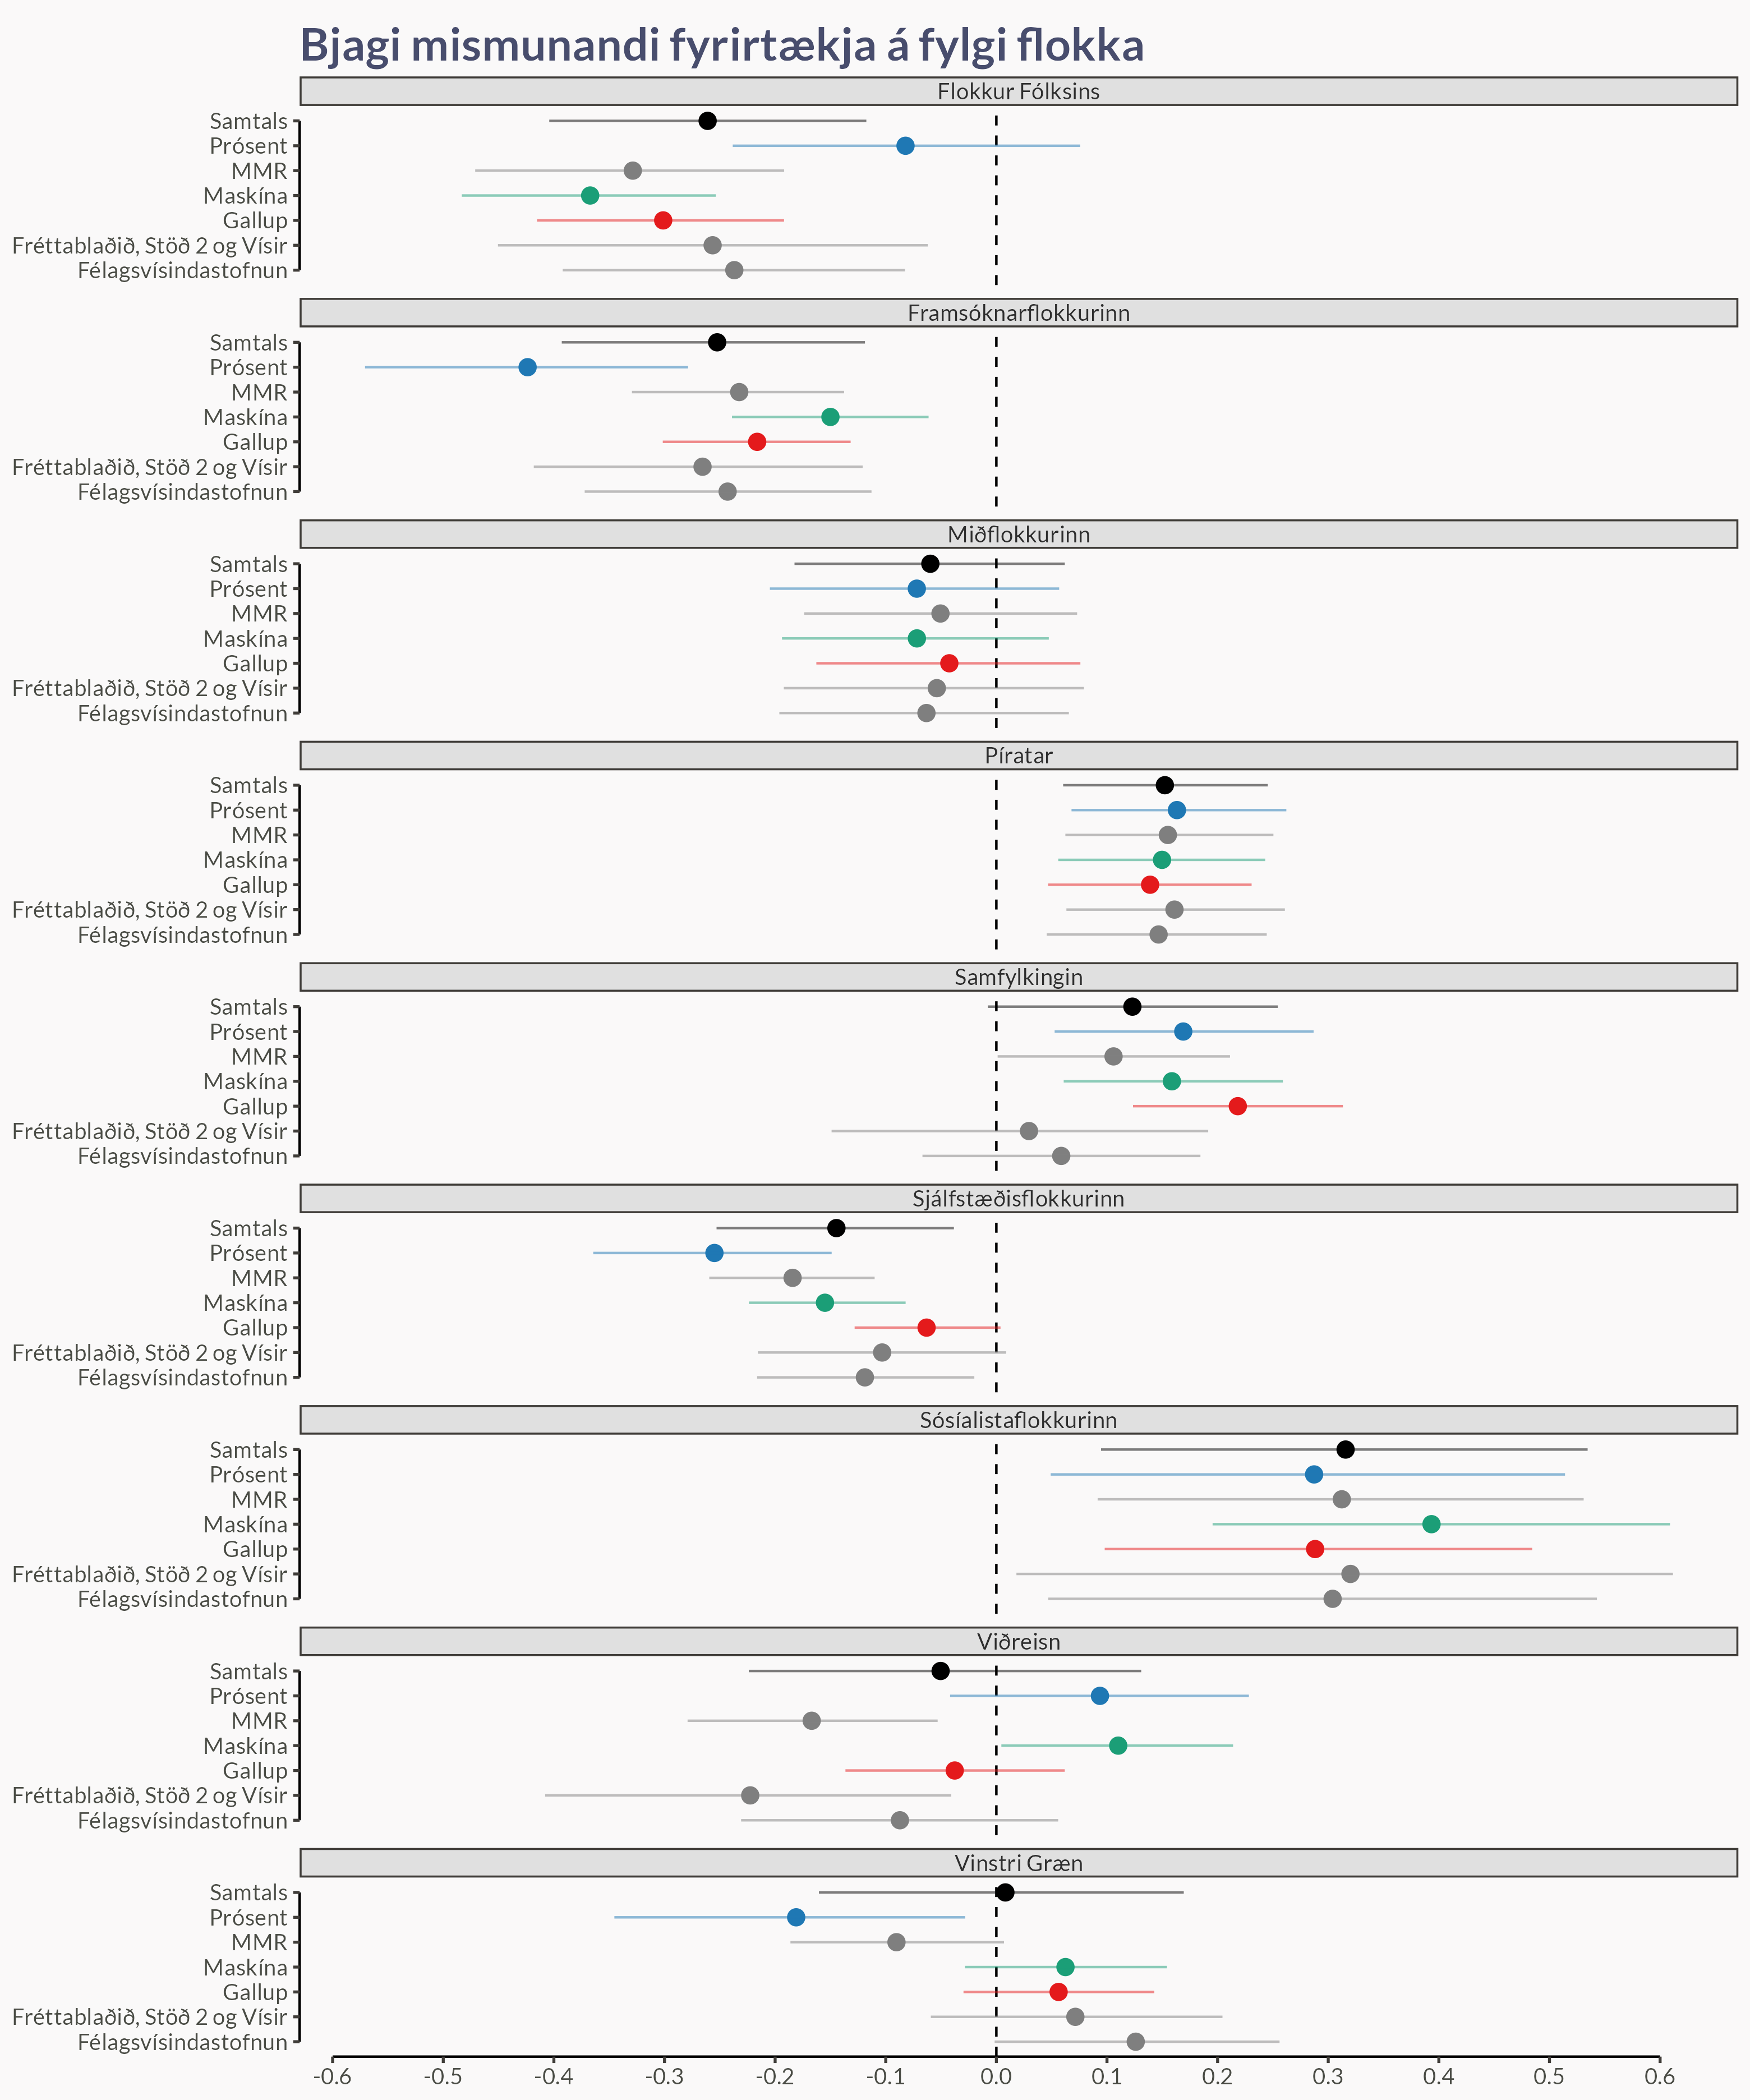

### Fundamentals Component

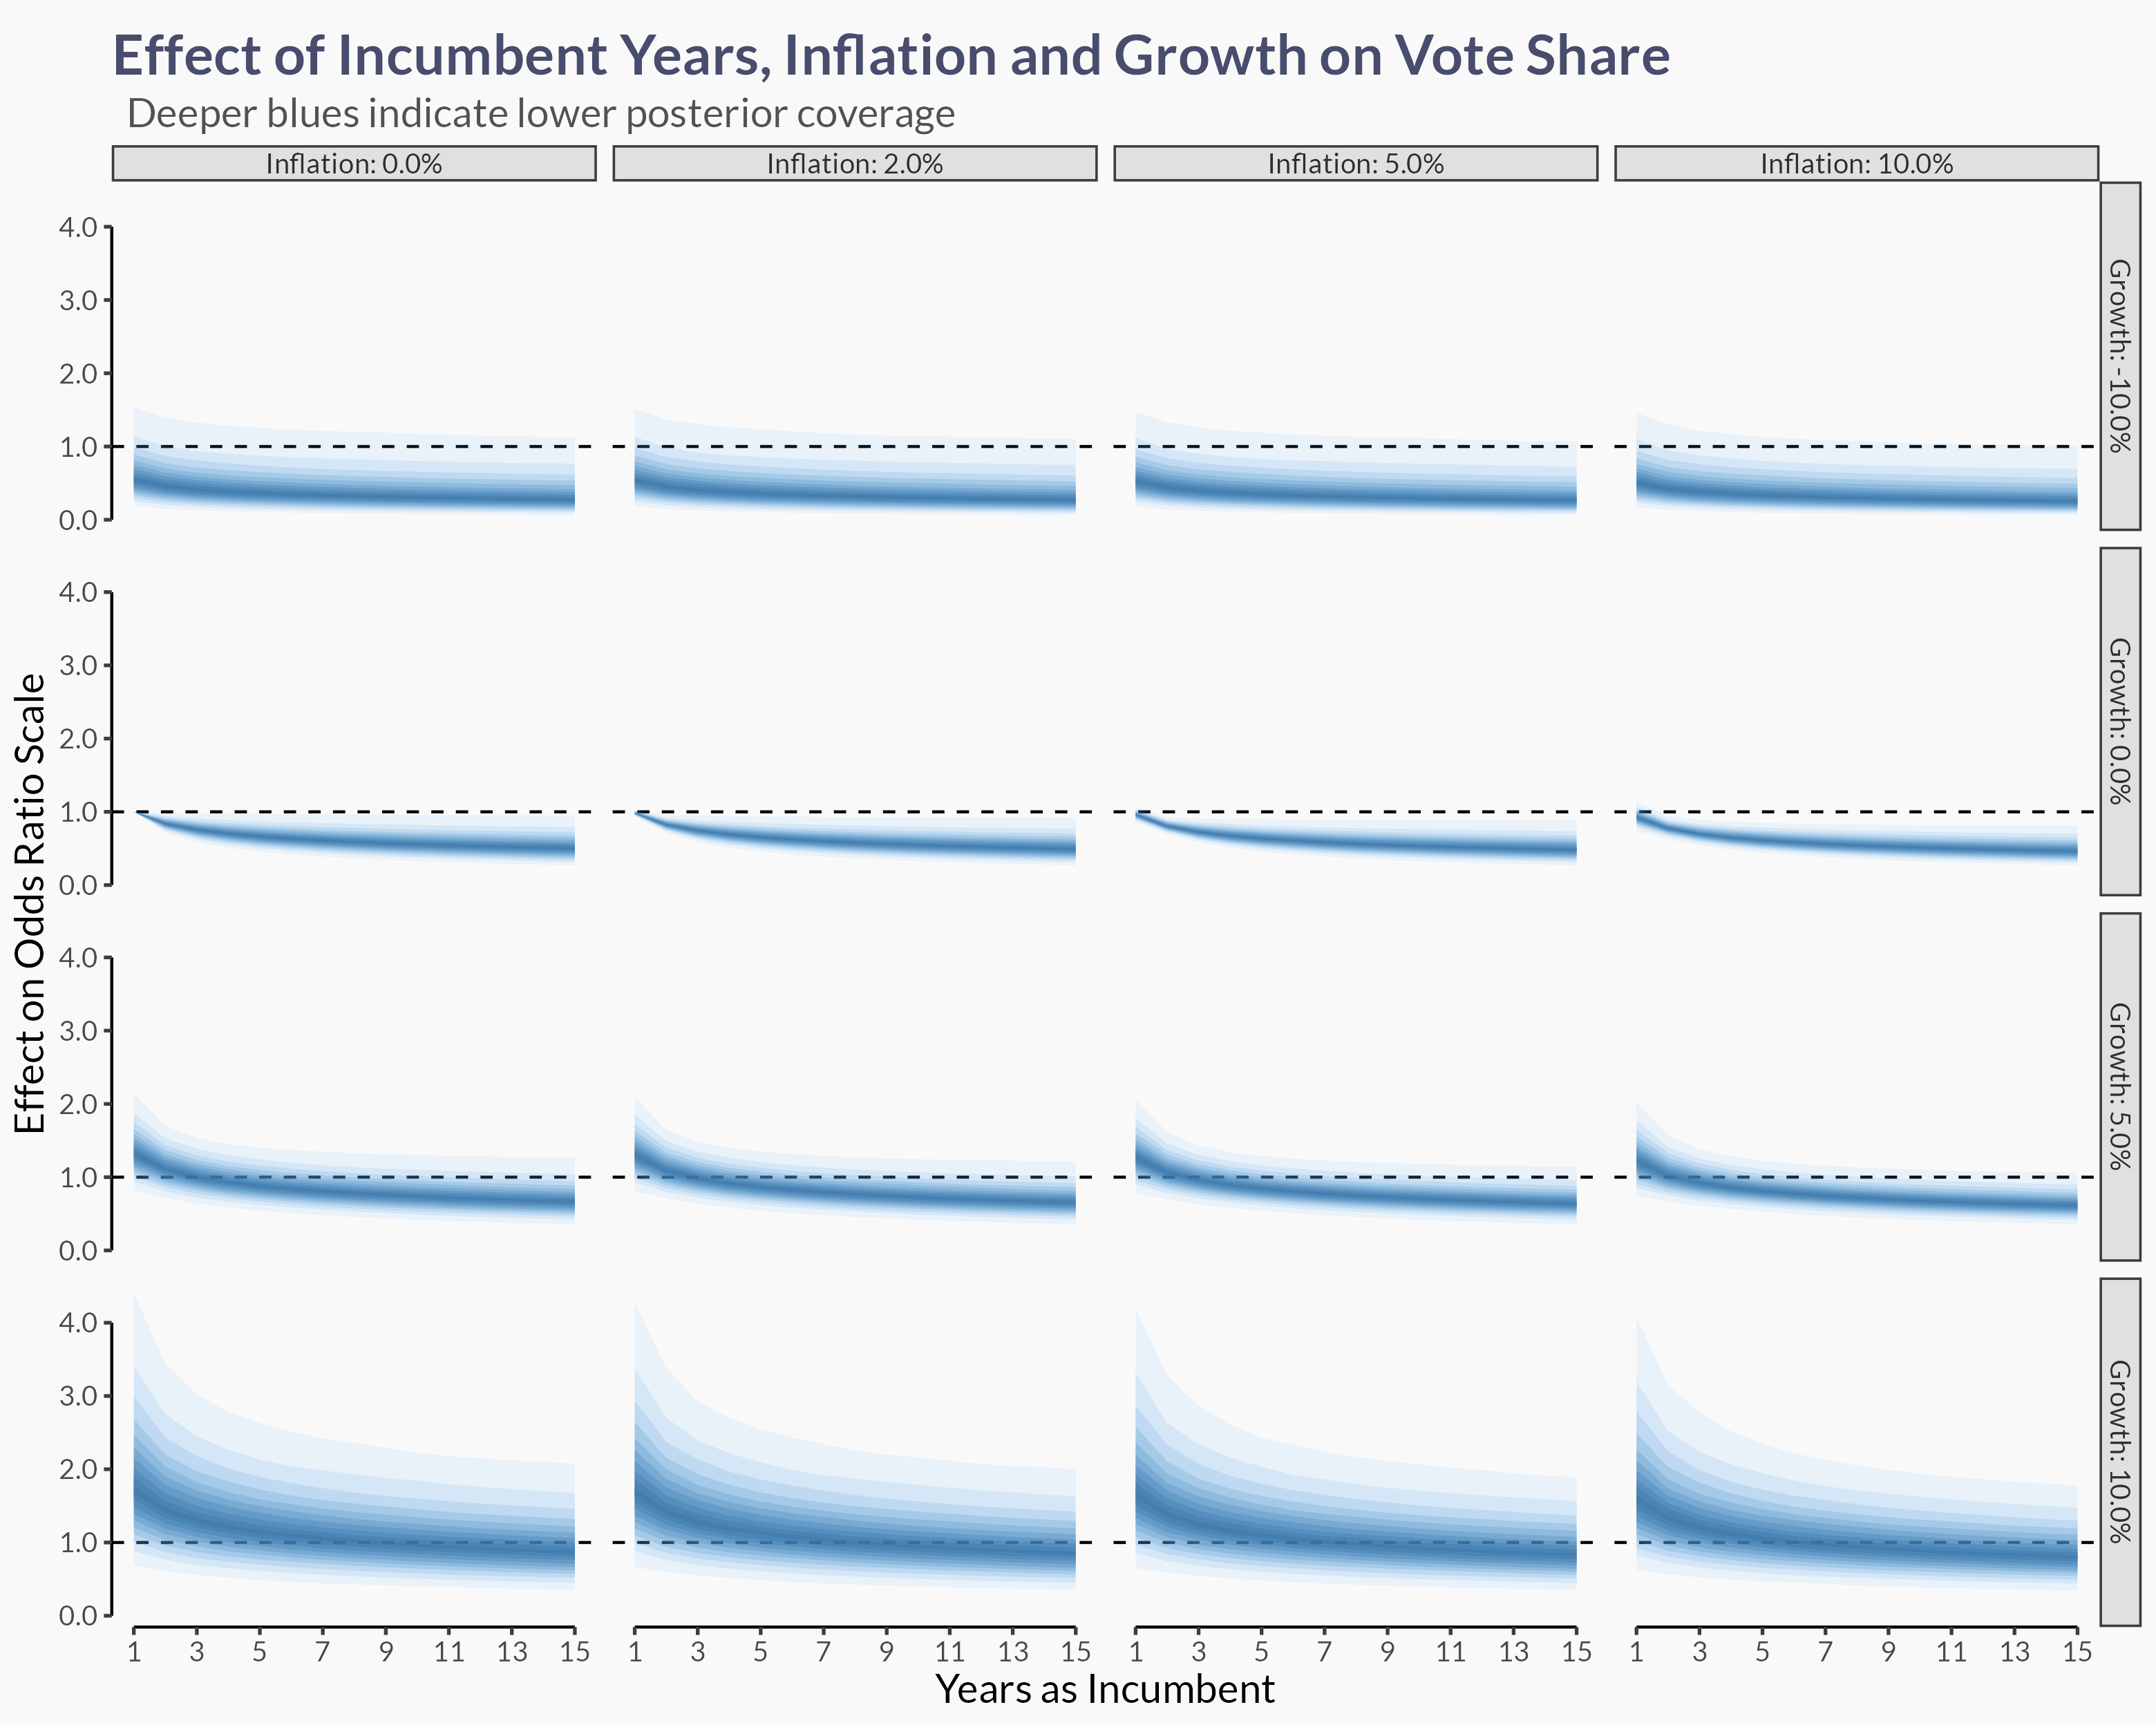

## Prediction

In [ ]:
source("R/plot_model_results.R")
make_plot()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: scales


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor


here() starts at /Users/brynjolfurjonsson/Metill/R/kosningaspa


Attaching package: 'arrow'


The following object is masked from 'package:lubridate':

    duration


The following object is masked from 'package:utils':

    timestamp


Rows: 3320 Columns: 4
── Column spe

ℹ It has been replaced by a ggproto system that can be extended.

(`geom_interactive_point()`).

Warning in set_attr(name = attrName, ids = as.integer(ids), values =
attrValue): Failed setting attribute 'data-id', mismatched lengths of ids and
values (most often, it occurs because of clipping or because of NAs in data)
Warning in set_attr(name = attrName, ids = as.integer(ids), values =
attrValue): Failed setting attribute 'data-id', mismatched lengths of ids and
values (most often, it occurs because of clipping or because of NAs in data)
Warning in set_attr(name = attrName, ids = as.integer(ids), values =
attrValue): Failed setting attribute 'data-id', mismatched lengths of ids and
values (most often, it occurs because of clipping or because of NAs in data)
Warning in set_attr(name = attrName, ids = as.integer(ids), values =
attrValue): Failed setting attribute 'data-id', mismatched lengths of ids and
values (most often, it occurs because of clipping or because of NAs in data)
Warning in set_attr(name = attrName, ids = as.integer(ids), values =
attrValue): Failed setting attribut